In [4]:
!pip3 install pytorch_msssim
!pip3 install astropy
!pip3 install hdbscan
!pip3 install -U pytorch_msssim
!pip3 install pytransit
!pip3 install lightkurve


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 38.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.0/308.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.4/724.4 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 7.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 91.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.

**GOAL**

The goal of this task is to detect planetary transits from light curve time series data. These transits are brief dips in a star’s brightness caused by an orbiting exoplanet passing in front of it. By analyzing these dips, the model should be able to classify whether a light curve contains a planetary transit or not.

So basically a Binary classification

**Initial ideas**
The idea is to simulate realistic light curves that mimic Kepler mission data and train a supervised deep learning model to detect planetary transits.

Also, it is given to generate synthetic data augumented with real transit curves

So, for data preprocessing, we use normalisation to remove big magnitude differences and preserve relative dips

This synthetic data must mimic the natural data, so some noise and some tranformations done

Time series data , but also we need to capture local dependencies, model can be something of a CNN+LSTM

Sigmoid output needed , since binary classification

SMOTE to be used to mitigate distribution skewness of synthetic data as the transit ones will be a minority class

Loss functions, Focal loss + BCE , this can handle class imbalance . There will be more no-trasit light curves than transit ones .

In [20]:
# Necessary imports and variables
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pytransit import QuadraticModel
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, LSTM, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import os
import lightkurve as lk
from imblearn.over_sampling import SMOTE

downsample_sz = 2000
n_epochs = 100
batch_sz = 64


In [6]:

# Normalise data
def normalize_light_curve_data(data):
   
    mean_flux = np.mean(data, axis=1, keepdims=True)
    std_flux = np.std(data, axis=1, keepdims=True)
    return (data - mean_flux) / std_flux

In [7]:
# Here we will do the data transformations to mimic the natural phenomenons
def augment_flux_data(flux):
    # data transformation
    if np.random.rand() > 0.5:
        flux += np.random.normal(0, 0.002, size=flux.shape)
    if np.random.rand() > 0.5:
        shift = np.random.randint(-5, 10)
        flux = np.roll(flux, shift)
    if np.random.rand() > 0.5:
        stretch = np.random.uniform(0.5, 1.5)
        flux = np.interp(np.linspace(0, len(flux), int(len(flux) * stretch)), np.arange(len(flux)), flux)
    return flux

In [8]:
# generate the synthetic trasits

def generate_synthetic_light_curve_data(num_transits=500, num_non_transits=5000, time_range=27, cadence=30, noise_level=0.0005, stellar_var_amp=0.0002):
    
    times = np.linspace(0, time_range, int(time_range * 24 * 60 / cadence))
    light_curves, labels = [], []

    for _ in range(num_transits + num_non_transits):
        has_transit = len(light_curves) < num_transits
        flux = np.ones_like(times)

        if has_transit:
            k = np.random.uniform(0.05, 0.15)
            p = np.random.uniform(2, 10)
            a = np.random.uniform(5, 20)
            i_rad = np.random.uniform(85, 90) * np.pi / 180
            e, w = 0.0, 90.0
            ldc = [np.random.uniform(0.2, 0.6), np.random.uniform(0.1, 0.4)]
            tm = QuadraticModel()
            tm.set_data(times)
            flux = tm.evaluate(k=k, t0=0.0, p=p, a=a, i=i_rad, e=e, w=w, ldc=ldc)

        variability = np.random.uniform(0, stellar_var_amp) * np.sin(2 * np.pi * times / np.random.uniform(5, 20))
        flux += variability + np.random.normal(0, noise_level, size=times.shape)

        flux = augment_flux_data(flux)
        light_curves.append(resample(flux,downsample_sz))
        labels.append(1 if has_transit else 0)

    return np.array(light_curves), np.array(labels)


In [9]:

# take some samples from original kepler dataset

def fetch_observational_light_curves(num_samples=500,downsample_sz=2000):
   
    transit_targets = ["Kepler-10", "Kepler-20", "Kepler-22", "Kepler-90"]
    non_transit_targets = ["KIC 8462852", "KIC 3542116", "KIC 2856960", "KIC 6034120"]

    observed_data, observed_labels = [], []

    for target in transit_targets:
        try:
            search = lk.search_lightcurve(target, mission="Kepler")
            if search:
                lc_collection = search.download_all()
                for lc in lc_collection[:int(num_samples * 0.1)]:
                    flux = lc.flux.value
                    flux = flux[np.isfinite(flux)]
                    if len(flux) > 100:
                        observed_data.append(resample(flux,downsample_sz))
                        observed_labels.append(1)
        except Exception as e:
            print(f"fetching error at  {target}: {e}")

    for target in non_transit_targets:
        try:
            search = lk.search_lightcurve(target, mission="Kepler")
            if search:
                lc_collection = search.download_all()
                for lc in lc_collection[:int(num_samples * 0.90)]:
                    flux = lc.flux.value
                    flux = flux[np.isfinite(flux)]
                    if len(flux) > 100:
                        observed_data.append(resample(flux,downsample_sz))
                        observed_labels.append(0)
        except Exception as e:
            print(f"Error fetching {target}: {e}")

    return np.array(observed_data), np.array(observed_labels)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Add, GlobalAveragePooling1D, Dense

def residual_block(x, filters, kernel_size, dropout_rate):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv1D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def tcn_model(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=5, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.3)(x)

    x = residual_block(x, 64, 5, 0.3)
    x = residual_block(x, 64, 5, 0.3)

    x = Conv1D(128, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)

    x = residual_block(x, 128, 3, 0.4)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)

    def focal_loss(alpha=0.25, gamma=2.0):
        def loss(y_true, y_pred):
            y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1.0 - 1e-7)
            pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            return tf.keras.backend.mean(-alpha * tf.keras.backend.pow(1 - pt, gamma) * tf.keras.backend.log(pt))
        return loss

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer, loss=focal_loss(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    model.summary()
    return model


In [23]:


def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        return K.mean(-alpha * K.pow(1 - pt, gamma) * K.log(pt))
    return loss




def bi_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = GaussianNoise(0.01)(inputs)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation="relu", kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    model.summary()
    return model

In [12]:
def plot_training_results(history):
   
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].set_title("Train-Val losses")
    axs[0].set_xlabel("n_epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axs[1].set_title("Train-val accuracy")
    axs[1].set_xlabel("n_epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

def plot_roc_pr_curves(y_true, y_pred_prob):
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    precisions, recalls, _ = precision_recall_curve(y_true, y_pred_prob)
    
    # ROC curve
    plt.figure(figsize=(6.4, 4.8))
    plt.plot(fpr, tpr, color='orange', label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    # Precision-Recall curve
    plt.figure(figsize=(6.4, 4.8))
    plt.plot(recalls, precisions, color='blue')
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title("PR-Curve")
    plt.show()

In [14]:
def train_n_evaluate(X_train, X_test, y_train, y_test):
    
    model = tcn_model((X_train.shape[1], 1))

    
    lr_scheduler = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, verbose=1, mode='max')
    early_stop = EarlyStopping(monitor='val_auc', patience=20, restore_best_weights=True, verbose=1, mode='max')

    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_sz,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop, lr_scheduler],
                        verbose=1)

    plot_training_results(history)

    y_pred_prob = model.predict(X_test, verbose=0).flatten()
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
    epsilon = 1e-10
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + epsilon)
    best_threshold = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5
    y_pred = (y_pred_prob > best_threshold).astype(int)

    print(f"\nbest: {best_threshold:.3f}")
    f1 = f1_score(y_test, y_pred)
    print(f"f1-score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Transit", "Transit"], yticklabels=["No Transit", "Transit"])
    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.title("confusion matrix")
    plt.show()

    plot_roc_pr_curves(y_test, y_pred_prob)

    report = classification_report(y_test, y_pred, target_names=["No Transit", "Transit"])
  

    return model


In [24]:
def train_n_evaluate2(X_train, X_test, y_train, y_test):
    model = bi_lstm_model((X_train.shape[1], 1))
    callbacks = [
        EarlyStopping(monitor="val_auc", patience=30, restore_best_weights=True, mode="max", verbose=1),
        ReduceLROnPlateau(monitor="val_auc", factor=0.3, patience=5,cooldown=2, min_lr=1e-6, mode="max", verbose=1),
    ]
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_sz,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    plot_training_results(history)

    y_pred_prob = model.predict(X_test).flatten()
    best_thresh = 0.5
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    if len(thresholds) > 0:
        best_thresh = thresholds[np.argmax(f1_scores)]
    y_pred = (y_pred_prob > best_thresh).astype(int)

    print(f"\best threshold: {best_thresh:.4f}")
    print(f"f1 Score: {f1_score(y_test, y_pred):.4f}")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix"), plt.xlabel("Predicted"), plt.ylabel("Actual")
    plt.show()
    plot_roc_pr_curves(y_test, y_pred_prob)
    print(classification_report(y_test, y_pred, target_names=["No Transit", "Transit"]))
    return model

In [16]:
def main():
   
    DATA_FILE = "transit_light_curve_data.npz"

    if os.path.exists(DATA_FILE):
       
        data = np.load(DATA_FILE)
        X_synthetic, y_synthetic = data["X_synth"], data["y_synth"]
        X_observed, y_observed = data["X_obs"], data["y_obs"]
    else:
      
        X_synthetic, y_synthetic = generate_synthetic_light_curve_data()
       
        X_observed, y_observed = fetch_observational_light_curves()
        np.savez(DATA_FILE, X_synth=X_synthetic, y_synth=y_synthetic, X_obs=X_observed, y_obs=y_observed)
     

    X_data = np.concatenate((X_synthetic, X_observed))
    y_data = np.concatenate((y_synthetic, y_observed))

    X_data = normalize_light_curve_data(X_data)

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

    # SMOTE is applied to handle class imbalance
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

    X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], 1)

    print("before SMOTE:", X_train.shape, y_train.shape)
    print("after SMOTE:", X_train_resampled.shape, y_train_resampled.shape)

    model1 = train_n_evaluate2(X_train_resampled, X_test[..., np.newaxis], y_train_resampled, y_test)
    model1.save('transit_classifier.keras')
    print("model saved")

before SMOTE: (4609, 2000) (4609,)
after SMOTE: (8124, 2000, 1) (8124,)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_2 (GaussianNoise)     │ (None, 2000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 2000, 128)           │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 2000, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.5882 - auc: 0.6935 - loss: 0.0482 - val_accuracy: 0.7962 - val_auc: 0.7602 - val_loss: 0.0432 - learning_rate: 1.0000e-04
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.8083 - auc: 0.8551 - loss: 0.0363 - val_accuracy: 0.9271 - val_auc: 0.8642 - val_loss: 0.0272 - learning_rate: 1.0000e-04
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.8667 - auc: 0.9166 - loss: 0.0294 - val_accuracy: 0.9271 - val_auc: 0.8907 - val_loss: 0.0253 - learning_rate: 1.0000e-04
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 212ms/step - accuracy: 0.8962 - auc: 0.9372 - loss: 0.0263 - val_accuracy: 0.9523 - val_auc: 0.9055 - val_loss: 0.0198 - learning_rate: 1.0000e-04
Epoch 5/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 27s 214ms/step - accuracy: 0.8985 - auc: 0.9448 - loss: 0.0254 - val_accuracy: 0.9167 - val_auc: 0.9138 - val_loss: 0.0198 - learning_rate: 1.0000e-04
Epoch 6/100
127/127 ━━━━━━━━━━━━━━━━━━━━

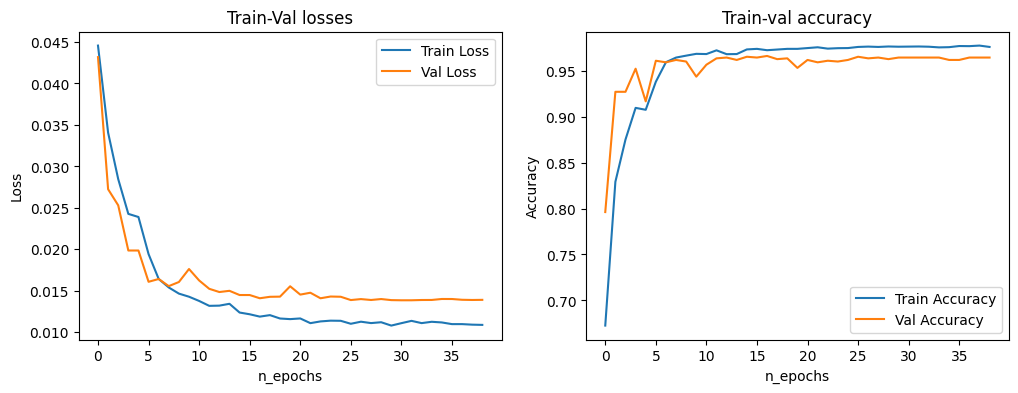

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step
est threshold: 0.5182
f1 Score: 0.8271


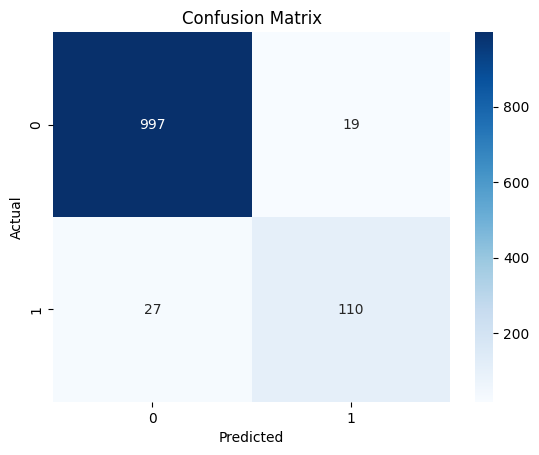

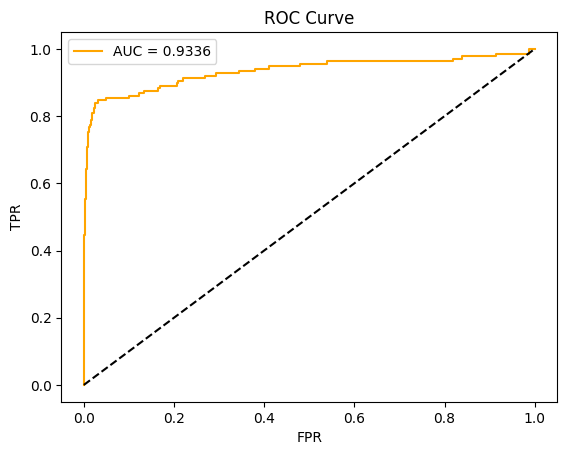

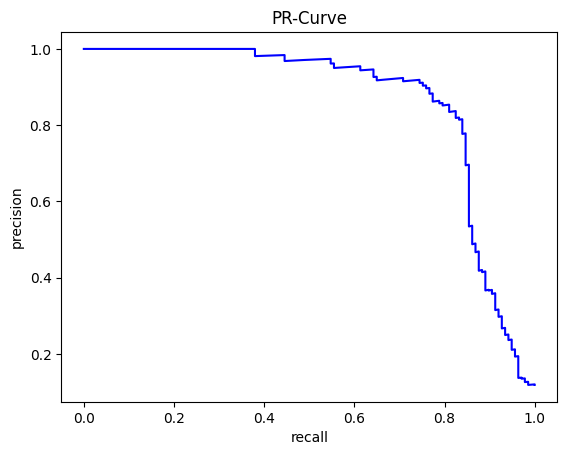

              precision    recall  f1-score   support

  No Transit       0.97      0.98      0.98      1016
     Transit       0.85      0.80      0.83       137

    accuracy                           0.96      1153
   macro avg       0.91      0.89      0.90      1153
weighted avg       0.96      0.96      0.96      1153

model saved


In [25]:

if __name__ == "__main__":
    main()
